In [89]:
#pip install pandas seaborn matplotlib numpy openpyxl statsmodels


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Intro:
aaron put the intro here

# Data Cleaning

Our model requires the merging of various datasets due to the complex nature of Solow's parameters (which typically is not measured directly. We first begin by cleaning and wrangling our economic data.

In [91]:
GDP_Data = pd.read_csv('RGDP_Data.csv', skiprows=3) #this is real GDP n 2015 USD
Capital_Stock_Data = pd.read_csv('Capital_Stock_Data.csv', skiprows=3)
Gross_Savings_Data = pd.read_csv('Gross_Savings_Data.csv', skiprows=3)
Population_Data = pd.read_csv('Population_Data.csv', skiprows=3)
Labor_Force_Data = pd.read_csv('Labor_Force_Data.csv', skiprows=3)

# List of countries to include
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Filter for the selected countries
GDP_Data1 = GDP_Data[GDP_Data['Country Name'].isin(selected_countries)]
Capital_Stock_Data1 = Capital_Stock_Data[Capital_Stock_Data['Country Name'].isin(selected_countries)]
Gross_Savings_Data1 = Gross_Savings_Data[Gross_Savings_Data['Country Name'].isin(selected_countries)]
Population_Data1 = Population_Data[Population_Data['Country Name'].isin(selected_countries)]
Labor_Force_Data1 = Labor_Force_Data[Labor_Force_Data['Country Name'].isin(selected_countries)]

# Select the first three columns, plus the columns within the year range 1992-2023
columns_GDP = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in GDP_Data.columns if col.isdigit() and 1992 <= int(col) <= 2023]

columns_GDI = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in Capital_Stock_Data.columns if col.isdigit() and 1992 <= int(col) <= 2023]

columns_Pop = ["Country Name", "Country Code", "Indicator Name"] + \
              [col for col in Population_Data.columns if col.isdigit() and 1990 <= int(col) <= 2023]

columns_savings = ["Country Name", "Country Code", "Indicator Name"] + \
                  [col for col in Gross_Savings_Data.columns if col.isdigit() and 1991 <= int(col) <= 2023]

columns_labor = ["Country Name", "Country Code", "Indicator Name"] + \
                [col for col in Labor_Force_Data.columns if col.isdigit() and 1990 <= int(col) <= 2023]

# Apply the columns filter to each dataset
GDP_Data2 = GDP_Data1[columns_GDP]
Capital_Stock_Data2 = Capital_Stock_Data1[columns_GDP]
Population_Data2 = Population_Data1[columns_Pop]
Gross_Savings_Data2 = Gross_Savings_Data1[columns_savings]
Labor_Force_Data2 = Labor_Force_Data1[columns_labor]


In [92]:
# Define a function to calculate annual growth starting from 1992
def calculate_annual_growth(row):
    growth_rates = {}
    # For 1992 to 2023, we compute growth using the previous year
    for year in range(1992, 2024):
        prev_year = str(year - 1)
        current_year = str(year)
        # Check for non-null and numeric data
        if (prev_year in row and current_year in row and
            pd.notnull(row[prev_year]) and pd.notnull(row[current_year]) and
            row[prev_year] != 0):
            growth_rates[current_year] = (row[current_year] - row[prev_year]) / row[prev_year]
        else:
            growth_rates[current_year] = pd.NA
    return pd.Series(growth_rates)

# Create Population Growth Rate Data
Population_Growth_Data = Population_Data2.apply(calculate_annual_growth, axis=1)
Population_Growth_Data = pd.concat([Population_Data2[["Country Name", "Country Code", "Indicator Name"]], Population_Growth_Data], axis=1)
Population_Growth_Data["Indicator Name"] = Population_Growth_Data["Indicator Name"].replace("Population, total", "Pop Annual Growth Rate")

# Create Labor Force Growth Rate Data
Labor_Force_Growth_Data = Labor_Force_Data2.apply(calculate_annual_growth, axis=1)
Labor_Force_Growth_Data = pd.concat([Labor_Force_Data2[["Country Name", "Country Code", "Indicator Name"]], Labor_Force_Growth_Data], axis=1)
Labor_Force_Growth_Data["Indicator Name"] = Labor_Force_Growth_Data["Indicator Name"].replace("Labor force, total", "Labor Annual Growth Rate")

# Define a function to calculate savings rate from total savings and total GDP
def calculate_savings_rate(row):
    savings_rate = {}
    for year in range(1992, 2024):
        year_str = str(year)
        if year_str in row and year_str in GDP_Data2.columns:
            gdp_value = GDP_Data2.loc[row.name, year_str]
            if pd.notnull(gdp_value) and gdp_value != 0 and pd.notnull(row[year_str]):
                savings_rate[year_str] = (row[year_str] / gdp_value)
            else:
                savings_rate[year_str] = pd.NA
        else:
            savings_rate[year_str] = pd.NA
    return pd.Series(savings_rate)

# Create Savings Rate Data
Savings_Rate_Data = Gross_Savings_Data2.iloc[:, 3:].apply(calculate_savings_rate, axis=1)
Savings_Rate_Data = pd.concat([Gross_Savings_Data2[["Country Name", "Country Code", "Indicator Name"]], Savings_Rate_Data], axis=1)

# Save the resulting datasets to an intermediate Excel file
with pd.ExcelWriter('Project_Data.xlsx') as writer:
    GDP_Data2.to_excel(writer, sheet_name='GDP Data', index=False)
    Capital_Stock_Data2.to_excel(writer, sheet_name='Capital Stock Data', index=False)
    Savings_Rate_Data.to_excel(writer, sheet_name='Savings Rate Data', index=False)
    Population_Growth_Data.to_excel(writer, sheet_name='Population Growth Rate Data', index=False)
    Labor_Force_Growth_Data.to_excel(writer, sheet_name='Labour Growth Rate Data', index=False)
    Labor_Force_Data2.to_excel(writer, sheet_name='Labour Data', index=False)
    Population_Data2.to_excel(writer, sheet_name='Population', index=False)

In [93]:
# Load each cleaned dataset
GDP_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='GDP Data')
Capital_Stock_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Capital Stock Data')
Gross_Savings_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Savings Rate Data')
Population_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Population Growth Rate Data')
Labor_Force_Data_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Labour Growth Rate Data')
Labor_Force_Data2_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Labour Data')
Population_Cleaned = pd.read_excel('Project_Data.xlsx', sheet_name='Population')

# Define a helper function to melt a dataframe from wide to long format
def melt_data(df, value_name):
    id_vars = ["Country Name", "Country Code", "Indicator Name"]
    year_cols = [col for col in df.columns if col.isdigit()]
    df_melted = df.melt(id_vars=id_vars, value_vars=year_cols, var_name="Year", value_name=value_name)
    df_melted["Year"] = pd.to_numeric(df_melted["Year"], errors='coerce')
    df_melted = df_melted.drop(columns=["Indicator Name"])
    return df_melted

# Melt each dataset to long format
gdp_long = melt_data(GDP_Data_Cleaned, "GDP")
capital_long = melt_data(Capital_Stock_Data_Cleaned, "Capital Stock")
savings_long = melt_data(Gross_Savings_Data_Cleaned, "Savings Rate")
population_long = melt_data(Population_Data_Cleaned, "Pop Growth Rate")
labor_long = melt_data(Labor_Force_Data_Cleaned, "Labour Force Growth Rate")
labor_long2 = melt_data(Labor_Force_Data2_Cleaned, "Labour Force")
population_long2 = melt_data(Population_Cleaned, "Population")


# Merge all datasets on Country Name, Country Code, and Year
merged_df = gdp_long.merge(capital_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(savings_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(labor_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(population_long, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(labor_long2, on=["Country Name", "Country Code", "Year"], how="left") \
                    .merge(population_long2, on=["Country Name", "Country Code", "Year"], how="left")

# Sort by Country Name and Year
merged_df.sort_values(["Country Name", "Year"], inplace=True)

# Save the final merged dataset
merged_df.to_excel("Final_Dataset.xlsx", index=False)

In [94]:
df = pd.read_excel("Final_Dataset.xlsx")
print(df.head())
df.info()

  Country Name Country Code  Year           GDP  Capital Stock  Savings Rate  \
0    Argentina          ARG  1992  313120000000   3.821158e+10      0.110822   
1    Argentina          ARG  1993  338818000000   4.660997e+10      0.120766   
2    Argentina          ARG  1994  358592000000   5.139950e+10      0.121265   
3    Argentina          ARG  1995  348389000000   4.773693e+10      0.133980   
4    Argentina          ARG  1996  367644000000   5.340632e+10      0.140460   

   Labour Force Growth Rate  Pop Growth Rate  Labour Force  Population  
0                  0.029395         0.013971      14275486    33568285  
1                  0.029565         0.013672      14697546    34027240  
2                  0.025143         0.013561      15067090    34488696  
3                  0.008917         0.013263      15201443    34946110  
4                  0.023820         0.012684      15563537    35389362  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data colu

Now that our data is prepared, we can visualize our parameters of interest.

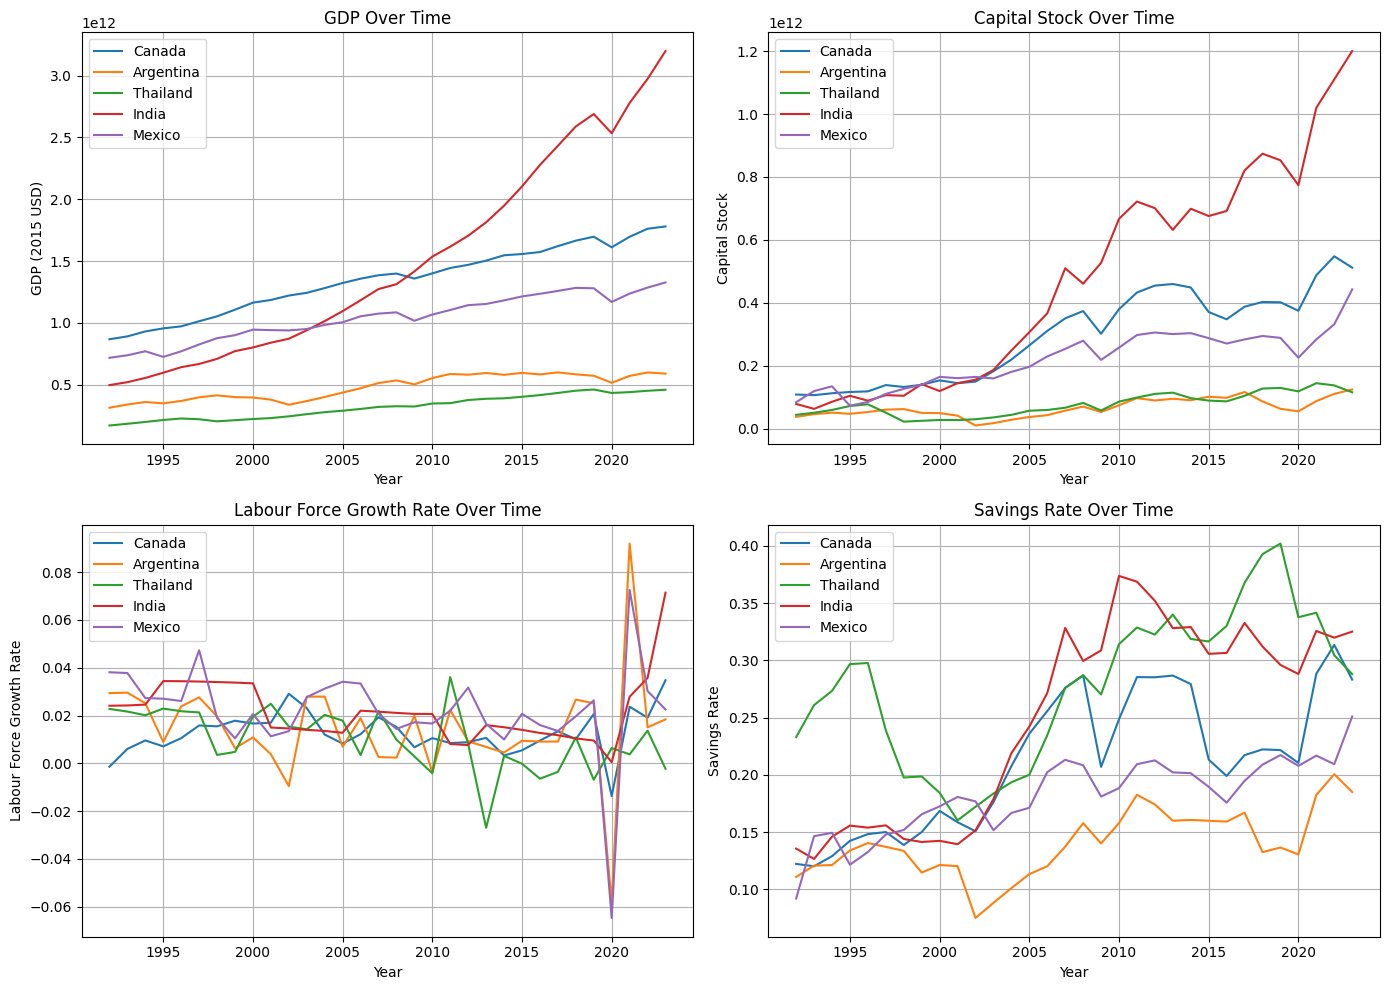

In [95]:
countries_to_plot = ["Canada", "Argentina", "Thailand", "India", "Mexico"]

# Filter the dataframe for these countries
plot_df = df[df["Country Name"].isin(countries_to_plot)]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
ax_gdp, ax_capital, ax_lfg, ax_savings = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]

# Plot GDP
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_gdp.plot(country_data["Year"], country_data["GDP"], label=country)
ax_gdp.set_title("GDP Over Time")
ax_gdp.set_xlabel("Year")
ax_gdp.set_ylabel("GDP (2015 USD)")
ax_gdp.grid(True)
ax_gdp.legend()

# Plot Capital Stock
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_capital.plot(country_data["Year"], country_data["Capital Stock"], label=country)
ax_capital.set_title("Capital Stock Over Time")
ax_capital.set_xlabel("Year")
ax_capital.set_ylabel("Capital Stock")
ax_capital.grid(True)
ax_capital.legend()

# Plot Labour Force Growth Rate
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_lfg.plot(country_data["Year"], country_data["Labour Force Growth Rate"], label=country)
ax_lfg.set_title("Labour Force Growth Rate Over Time")
ax_lfg.set_xlabel("Year")
ax_lfg.set_ylabel("Labour Force Growth Rate")
ax_lfg.grid(True)
ax_lfg.legend()

# Plot Savings Rate
for country in countries_to_plot:
    country_data = plot_df[plot_df["Country Name"] == country].sort_values("Year")
    ax_savings.plot(country_data["Year"], country_data["Savings Rate"], label=country)
ax_savings.set_title("Savings Rate Over Time")
ax_savings.set_xlabel("Year")
ax_savings.set_ylabel("Savings Rate")
ax_savings.grid(True)
ax_savings.legend()

plt.tight_layout()
plt.show()


# Data Analysis

### Analyzing Economic Interdependence and the Role of Non-Economic Variables in Economic Growth


Before conducting the steady-state analysis, we aim to apply data analytics to explore questions related to **regional and global economic interdependence** and to **regress key non-economic variables** to better understand their dynamics within an economy. Our analysis will be structured into three main parts.

**Part 1: Correlation Analysis of Core Economic Variables**  
First, we will conduct a **correlation analysis** of core economic variables, including **GDP per capita, labor force growth rate, savings rate, population, and capital stock** across countries in our dataset. This analysis will allow us to address key questions about economic interdependence, such as:  

- Firstly, ARE global economies interdependent with one another?
- How strong is the interdependence between specific economies?  
- Which countries exhibit the highest and lowest degrees of economic interdependence?  
- How does the level of interdependence differ between high-income, middle-income, and low-income countries?
- How has economic interdependence evolved over time (are countries more dependent today or in the past)?

**Part 2: Regional Correlation Analysis**  

It is important to note that **correlation does not imply causation**, and it would be overly simplistic to equate correlation with true economic interdependence. However, for the purposes of this analysis, we will operate under the assumption that a high correlation between the core economic variables of two countries reflects a degree of economic interdependence.

Our approach begins by **classifying countries into regional groups** and conducting a **regional correlation analysis**. This analysis will be carried out in two stages. First, we will analyze the correlation of core economic variables within each region, such as **the EU, Middle East, Asia, and Latin America**, to identify which regions exhibit the highest levels of internal economic interdependence. Second, we will conduct a cross-regional analysis to measure the correlation of core economic variables between regions, providing insight into cross-regional linkages.

This analysis will allow us to answer key questions, such as:  
- Which regions (e.g., EU, Middle East, Asia) exhibit the highest and lowest levels of internal economic interdependence?  
- Which regional pairings (e.g., EU-Middle East, Asia-Latin America) exhibit the strongest cross-regional economic interdependence?  

Additionally, given the influence of major global powers, we will analyze the extent of economic interdependence between **the USA and China**—the two most influential economies—and each of the regional groups. This will allow us to determine the degree to which these global powers are economically linked with different regions, shedding light on the global structure of economic interdependence.


**Part 3: Regression Analysis of Non-Economic Variables**  
In the third section, we will incorporate key non-economic variables that are hypothesized to influence economic growth. Specifically, we will import data on the following variables:  
- **Freedom House Index** (which measures political rights and civil liberties)  
- **Life Expectancy Rate**  
- **Literacy Rate**  
- **Gini Coefficient** (which measures income inequality)  
- **V-Dem measure of regime types**  

These variables will be regressed on key economic outcomes, including:  
- **GDP** (to understand the direct relationship between these variables and economic growth)  
- **GDP per capita** (as a measure of welfare, beyond economic growth)  

This three-part analysis aims to provide a comprehensive view of economic interdependence and the role of non-economic variables in shaping key economic outcomes.


### Part 1: Correlational Analysis of Core Economic Variables

In [96]:
# Cell 1: Correlation Matrix Table of GDP Across All Countries

# Load the final merged dataset
merged_df0 = pd.read_excel("Final_Dataset.xlsx")

# Check if required columns exist
required_columns = ['Country Name', 'Year', 'GDP']
missing_columns = [col for col in required_columns if col not in merged_df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the dataset: {missing_columns}")

# Pivot the data to have countries as columns and years as rows
gdp_pivot = merged_df0.pivot(index='Year', columns='Country Name', values='GDP')

# Compute the correlation matrix
corr_matrix = gdp_pivot.corr()

print(f"Correlation Matrix of GDP Across {len(corr_matrix.columns)} Countries:")
display(corr_matrix)


Correlation Matrix of GDP Across 24 Countries:


Country Name,Argentina,Australia,Bangladesh,Brazil,Canada,China,Colombia,Germany,Greece,India,...,Mexico,Mozambique,Poland,Rwanda,Saudi Arabia,South Africa,Tanzania,Thailand,Uganda,United States
Country Name,,,,,,,,,,,,,,,,,,,,,
Argentina,1.000000,0.914529,0.831901,0.968775,0.909290,0.872942,0.921563,0.909594,0.266576,0.871224,...,0.925215,0.911198,0.896283,0.848965,0.917211,0.960309,0.862160,0.929381,0.893915,0.891345
Australia,0.914529,1.000000,0.964419,0.966339,0.992413,0.977414,0.983905,0.989933,0.266677,0.979456,...,0.980347,0.992425,0.993625,0.967060,0.978339,0.978931,0.976976,0.988871,0.989039,0.993377
Bangladesh,0.831901,0.964419,1.000000,0.889631,0.935639,0.994922,0.977118,0.954028,0.091065,0.994369,...,0.913459,0.974315,0.984122,0.995113,0.972897,0.901535,0.996360,0.951017,0.989124,0.954394
Brazil,0.968775,0.966339,0.889631,1.000000,0.963319,0.921134,0.953856,0.949928,0.303221,0.917868,...,0.957701,0.954329,0.945866,0.902572,0.946810,0.988928,0.913857,0.967767,0.943781,0.947514
Canada,0.909290,0.992413,0.935639,0.963319,1.000000,0.949373,0.962783,0.989147,0.353004,0.955490,...,0.991143,0.974396,0.978896,0.938504,0.955001,0.980381,0.950167,0.977382,0.966093,0.996151
China,0.872942,0.977414,0.994922,0.921134,0.949373,1.000000,0.990588,0.967936,0.094016,0.997807,...,0.932418,0.989752,0.990209,0.994586,0.988619,0.931878,0.999247,0.972334,0.997059,0.961558
Colombia,0.921563,0.983905,0.977118,0.953856,0.962783,0.990588,1.000000,0.975926,0.137443,0.990357,...,0.953626,0.993359,0.988262,0.981407,0.995727,0.960591,0.987575,0.985313,0.992972,0.966363
Germany,0.909594,0.989933,0.954028,0.949928,0.989147,0.967936,0.975926,1.000000,0.252938,0.972818,...,0.986566,0.985072,0.985201,0.956245,0.971191,0.971568,0.967967,0.982143,0.977058,0.988593
Greece,0.266576,0.266677,0.091065,0.303221,0.353004,0.094016,0.137443,0.252938,1.000000,0.117138,...,0.337506,0.163880,0.216069,0.097790,0.107381,0.336197,0.105366,0.222395,0.152820,0.331279


**Here we found an issue that most countries were far too correlated. This means that the dimension of time was causing this issue because if all countries are growing throughout time, then our estimation of correlation between these countries will be inflated. So, to adjust for this, we will instead find GDP growth rate and then do our correlation based on that. This will resolve the inflated results due to time, and we should actually be able to see the true correlation of economic growth between these countries.**

In [97]:
# Load the final merged dataset again
merged_df = pd.read_excel("Final_Dataset.xlsx")

# Calculate GDP Growth Rate
merged_df = merged_df.sort_values(['Country Name', 'Year'])
merged_df['GDP Growth Rate'] = merged_df.groupby('Country Name')['GDP'].pct_change()

merged_df.head()

,Country Name,Country Code,Year,GDP,Capital Stock,Savings Rate,Labour Force Growth Rate,Pop Growth Rate,Labour Force,Population,GDP Growth Rate
0,Argentina,ARG,1992,313120000000,3.821158e+10,0.110822,0.029395,0.013971,14275486,33568285,NaN
1,Argentina,ARG,1993,338818000000,4.660997e+10,0.120766,0.029565,0.013672,14697546,34027240,0.082071
2,Argentina,ARG,1994,358592000000,5.139950e+10,0.121265,0.025143,0.013561,15067090,34488696,0.058362
3,Argentina,ARG,1995,348389000000,4.773693e+10,0.133980,0.008917,0.013263,15201443,34946110,-0.028453
4,Argentina,ARG,1996,367644000000,5.340632e+10,0.140460,0.023820,0.012684,15563537,35389362,0.055269


In [98]:
# Pivot the data to have countries as columns and years as rows
gdp_growth_pivot = merged_df.pivot(index='Year', columns='Country Name', values='GDP Growth Rate')

# Compute the correlation matrix
corr_matrix = gdp_growth_pivot.corr()

print(f"Correlation Matrix of GDP Growth Rate Across {len(corr_matrix.columns)} Countries:")
display(corr_matrix)

Correlation Matrix of GDP Growth Rate Across 24 Countries:


Country Name,Argentina,Australia,Bangladesh,Brazil,Canada,China,Colombia,Germany,Greece,India,...,Mexico,Mozambique,Poland,Rwanda,Saudi Arabia,South Africa,Tanzania,Thailand,Uganda,United States
Country Name,,,,,,,,,,,,,,,,,,,,,
Argentina,1.000000,0.260605,0.233902,0.568928,0.460639,0.535874,0.657506,0.487724,0.256196,0.456203,...,0.651748,0.227704,0.535593,-0.131259,0.600226,0.589480,0.074510,0.230487,0.113239,0.520130
Australia,0.260605,1.000000,-0.111669,0.406826,0.662421,0.373215,0.225163,0.291755,0.463746,0.395531,...,0.520240,0.477649,0.474890,0.018990,0.111828,0.542414,-0.116333,0.344751,0.337007,0.575944
Bangladesh,0.233902,-0.111669,1.000000,-0.012852,0.160198,-0.144368,0.454476,0.409638,0.056038,0.382999,...,0.212911,-0.274126,0.307001,0.291335,0.400330,0.204928,0.478275,0.048495,-0.105384,0.107945
Brazil,0.568928,0.406826,-0.012852,1.000000,0.537085,0.622540,0.623343,0.414089,0.206367,0.236883,...,0.384925,0.129632,0.398553,-0.074631,0.267051,0.675053,-0.014347,0.467813,0.342838,0.336492
Canada,0.460639,0.662421,0.160198,0.537085,1.000000,0.310687,0.517697,0.749609,0.551001,0.501700,...,0.740486,0.264033,0.601758,-0.023571,0.292149,0.708079,0.057417,0.329696,0.066461,0.862470
China,0.535874,0.373215,-0.144368,0.622540,0.310687,1.000000,0.492716,0.240229,0.148295,0.369503,...,0.236499,0.443421,0.442576,-0.173387,0.088422,0.650711,0.017685,0.533812,0.603099,0.253037
Colombia,0.657506,0.225163,0.454476,0.623343,0.517697,0.492716,1.000000,0.497067,0.295575,0.521208,...,0.443505,0.050679,0.564512,0.030897,0.567780,0.690758,0.207944,0.405214,0.205349,0.377324
Germany,0.487724,0.291755,0.409638,0.414089,0.749609,0.240229,0.497067,1.000000,0.301998,0.405262,...,0.675602,0.126032,0.557718,0.059368,0.395164,0.636277,0.272388,0.244181,0.086253,0.644233
Greece,0.256196,0.463746,0.056038,0.206367,0.551001,0.148295,0.295575,0.301998,1.000000,0.419908,...,0.392244,0.191352,0.522968,0.113830,0.031988,0.505600,0.038298,0.156861,0.088461,0.590810


**These results are more accurate. One way we can tell is by looking at the correlation between some countries which we know are highly correlated. Like US-Canada which we see have a correlation of 0.86 which is strong. Two things to notice are even countries that we would expect to have very high correlations like China-India don't and this can be because maybe they were less dependent in the past, which is making the correlation value go down. Lets check this by isolating China-India correlation throughout time.**

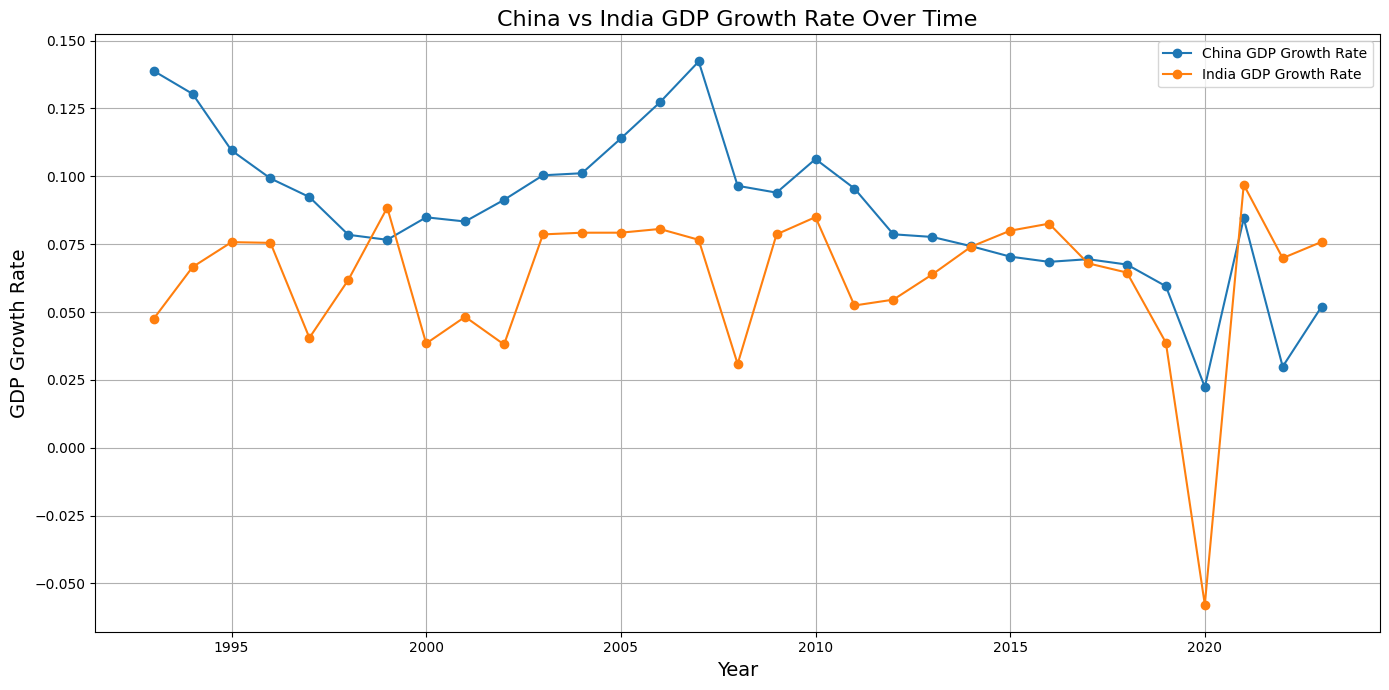

In [99]:
# Cell 2: Correlation Between China and India GDP Growth Rate Over Time

# Select China and India GDP Growth Rate
china_growth = gdp_growth_pivot['China']
india_growth = gdp_growth_pivot['India']

# Drop years where either China or India has NaN GDP Growth Rate
growth_df = pd.DataFrame({
    'China GDP Growth Rate': china_growth,
    'India GDP Growth Rate': india_growth,
}).dropna()

# Plot the GDP Growth Rates of China and India over time
plt.figure(figsize=(14, 7))
plt.plot(growth_df.index, growth_df['China GDP Growth Rate'], label='China GDP Growth Rate', marker='o')
plt.plot(growth_df.index, growth_df['India GDP Growth Rate'], label='India GDP Growth Rate', marker='o')
plt.title('China vs India GDP Growth Rate Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('GDP Growth Rate', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Our guess was correct as we see that China and India correlation is much higher in the past few years than in the past. We can see this because China and India are moving similarly last few years than in the past. Now, lets try to group these correlations by different income levels.**


Top 5 Countries Most Correlated with United States:
Country Name
Canada          0.862470
Mexico          0.777294
Japan           0.696506
Germany         0.644233
South Africa    0.600935
Name: United States, dtype: float64

Top 5 Countries Least Correlated with United States:
Country Name
Bangladesh    0.107945
Uganda       -0.013848
Rwanda       -0.021094
Indonesia    -0.039793
Tanzania     -0.059620
Name: United States, dtype: float64

Top 5 Countries Most Correlated with China:
Country Name
South Africa    0.650711
Brazil          0.622540
Uganda          0.603099
Argentina       0.535874
Thailand        0.533812
Name: China, dtype: float64

Top 5 Countries Least Correlated with China:
Country Name
Kenya           0.104759
Saudi Arabia    0.088422
Tanzania        0.017685
Bangladesh     -0.144368
Rwanda         -0.173387
Name: China, dtype: float64
Egypt not found in the correlation matrix.

Top 5 Countries Most Correlated with Egypt:
Series([], dtype: float64)

Top 5 Countries 

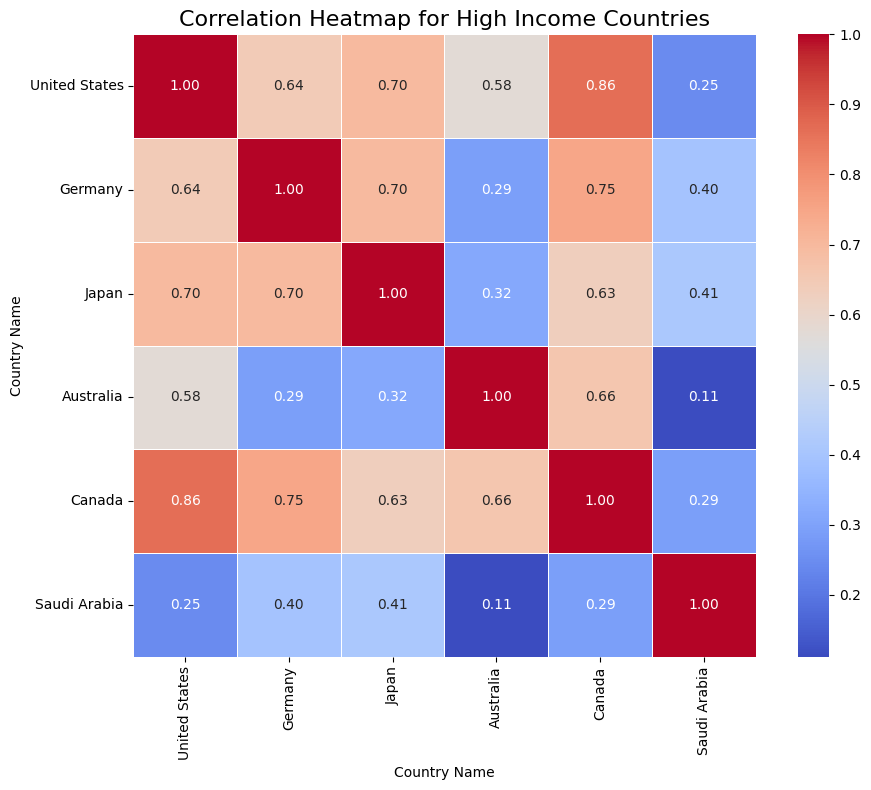

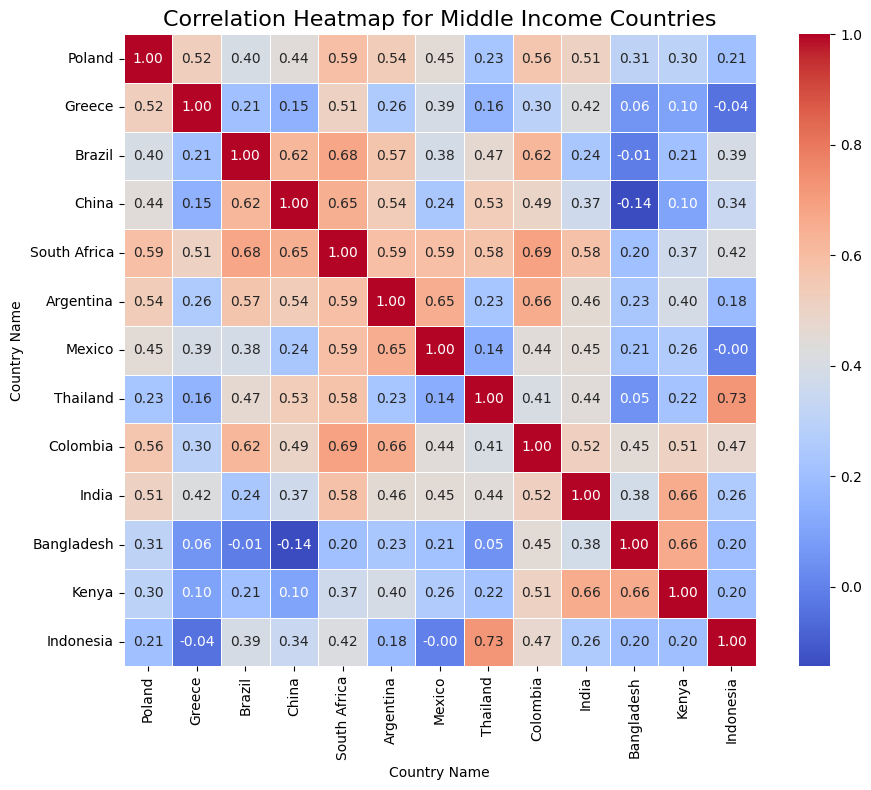

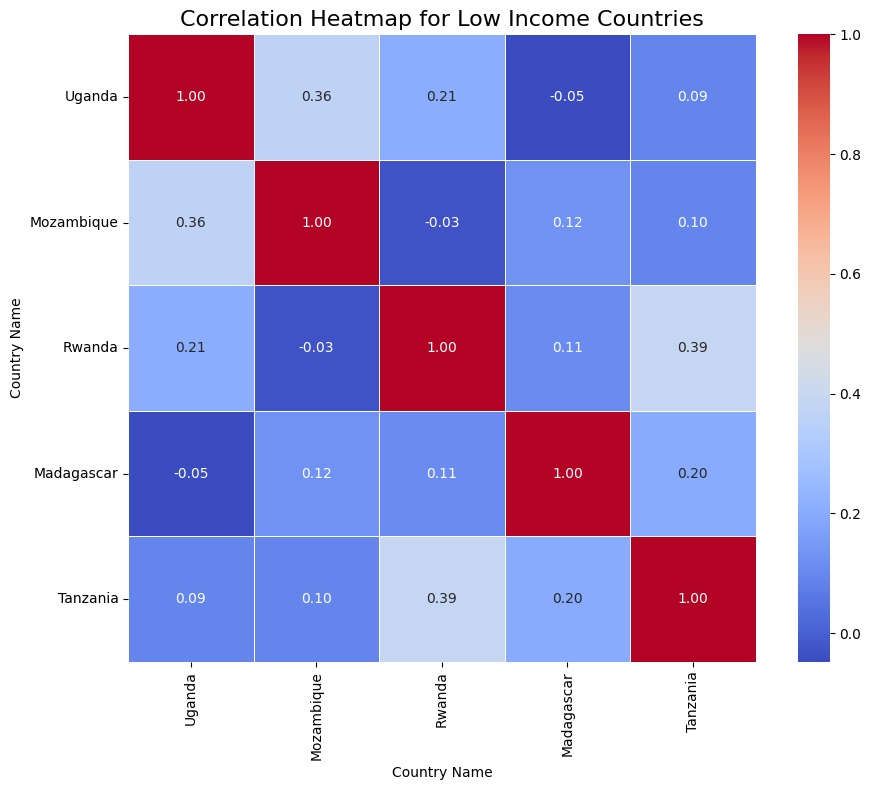


Average Correlation Between Income Groups:


,High Income,Middle Income,Low Income
High Income,0.51,0.39,0.17
Middle Income,0.39,0.38,0.19
Low Income,0.17,0.19,0.15


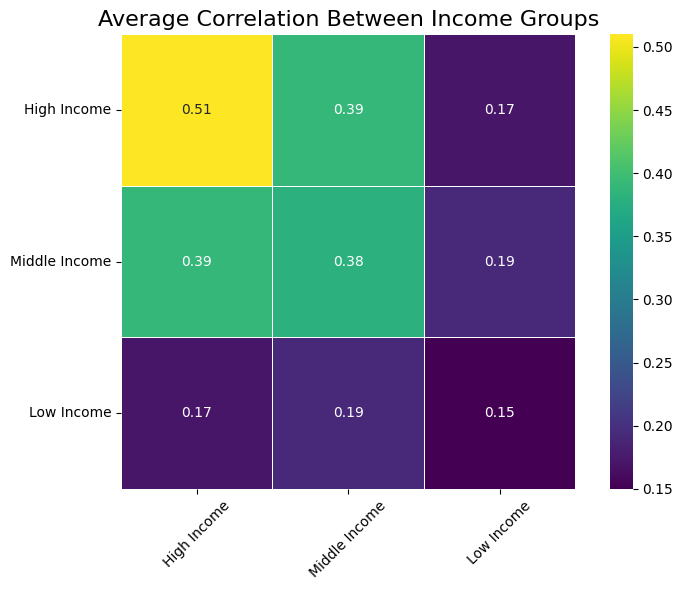

In [100]:
# Cell 2: Identifying Most and Least Correlated Countries & Correlation by Income Groups

# Compute the correlation matrix
corr_matrix = gdp_growth_pivot.corr()

# List of countries to analyze for most and least correlated
countries_of_interest = ["United States", "China", "Egypt"]

# Function to get top 5 most and least correlated countries for a given country
def get_top_correlations(corr_matrix, country, top_n=5):
    if country not in corr_matrix.columns:
        print(f"{country} not found in the correlation matrix.")
        return pd.Series(dtype='float'), pd.Series(dtype='float')
    sorted_corr = corr_matrix[country].sort_values(ascending=False)
    top_corr = sorted_corr[sorted_corr.index != country].head(top_n)
    bottom_corr = sorted_corr.tail(top_n)
    return top_corr, bottom_corr

# Display the top 5 most and least correlated countries for each country of interest
for country in countries_of_interest:
    top_corr, bottom_corr = get_top_correlations(corr_matrix, country)
    print(f"\nTop 5 Countries Most Correlated with {country}:")
    print(top_corr)
    print(f"\nTop 5 Countries Least Correlated with {country}:")
    print(bottom_corr)

# Define income groups based on World Bank classifications
high_income = ["United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia"]
middle_income = ["Poland", "Greece", "Brazil", "China", "South Africa", "Russia", "Argentina",
                "Mexico", "Turkey", "Thailand", "Colombia", "India", "Egypt", "Bangladesh",
                "Vietnam", "Kenya", "Indonesia"]
low_income = ["Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"]


#################################################### FROM HERE ###############################################

# Create a dictionary for income groups
income_groups = {
    "High Income": high_income,
    "Middle Income": middle_income,
    "Low Income": low_income
}

# Get the list of all available countries in the correlation matrix
available_countries = corr_matrix.columns.tolist()

# Adjust income groups to include only available countries
for group in income_groups:
    income_groups[group] = [country for country in income_groups[group] if country in available_countries]

# Function to plot correlation heatmap for a given group
def plot_income_correlation(group_name, countries):
    # Ensure that the countries exist in the correlation matrix
    if not countries:
        print(f"No available countries found for {group_name} group.")
        return
    group_corr = corr_matrix.loc[countries, countries]

    plt.figure(figsize=(10, 8))
    sns.heatmap(group_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, square=True)
    plt.title(f'Correlation Heatmap for {group_name} Countries', fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Plot correlation heatmaps for each income group
for group, countries in income_groups.items():
    plot_income_correlation(group, countries)

# Additionally, analyze average correlations between different income groups
group_names = list(income_groups.keys())
average_corr_between_groups = pd.DataFrame(index=group_names, columns=group_names)

for group1 in group_names:
    for group2 in group_names:
        # Select the relevant subset of the correlation matrix
        subset = corr_matrix.loc[income_groups[group1], income_groups[group2]]
        # Convert to numpy array and exclude self-correlations if same group
        if group1 == group2:
            mask = ~np.eye(len(subset), dtype=bool)
            subset_values = subset.values[mask]
        else:
            subset_values = subset.values.flatten()
        # Remove NaN values
        subset_values = subset_values[~np.isnan(subset_values)]
        # Calculate the average correlation
        if len(subset_values) > 0:
            avg_corr = np.mean(subset_values)
            average_corr_between_groups.loc[group1, group2] = round(avg_corr, 2)
        else:
            average_corr_between_groups.loc[group1, group2] = np.nan

################################################# TO HERE, TOO COMPLEX #######################################

print("\nAverage Correlation Between Income Groups:")
display(average_corr_between_groups.astype(float))

# Plot the average correlation heatmap between income groups
plt.figure(figsize=(8, 6))
sns.heatmap(average_corr_between_groups.astype(float), annot=True, fmt=".2f", cmap='viridis', linewidths=.5, square=True)
plt.title('Average Correlation Between Income Groups', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**From this, we can see that...**

### Part 2: Regional Correlationa Analysis

**Second, we will split our countries into regions and check correlation within and between regions**

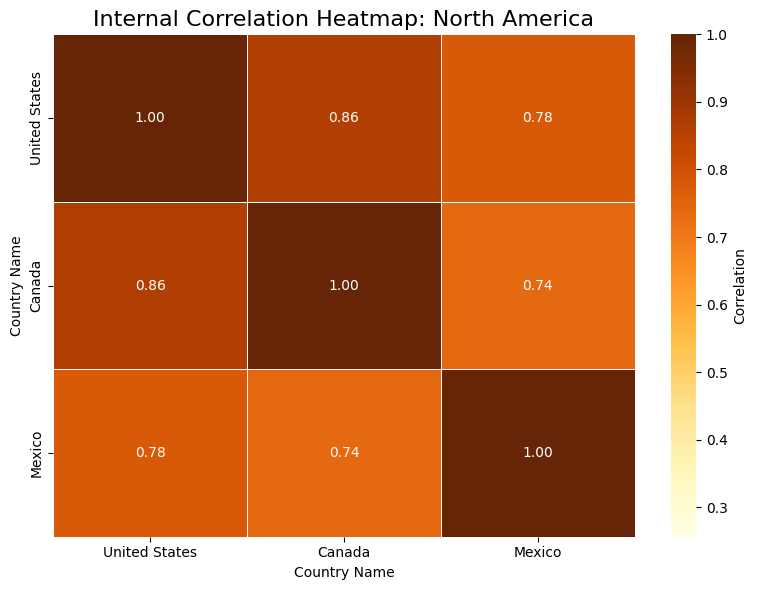

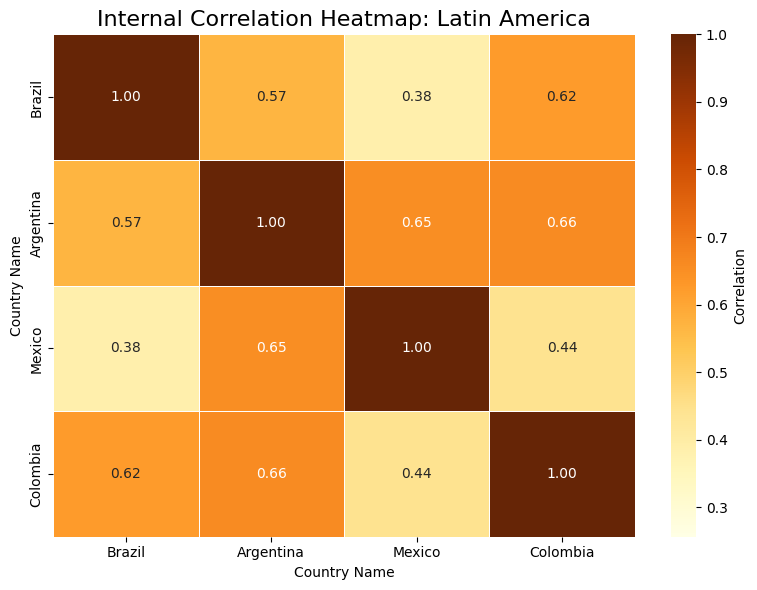

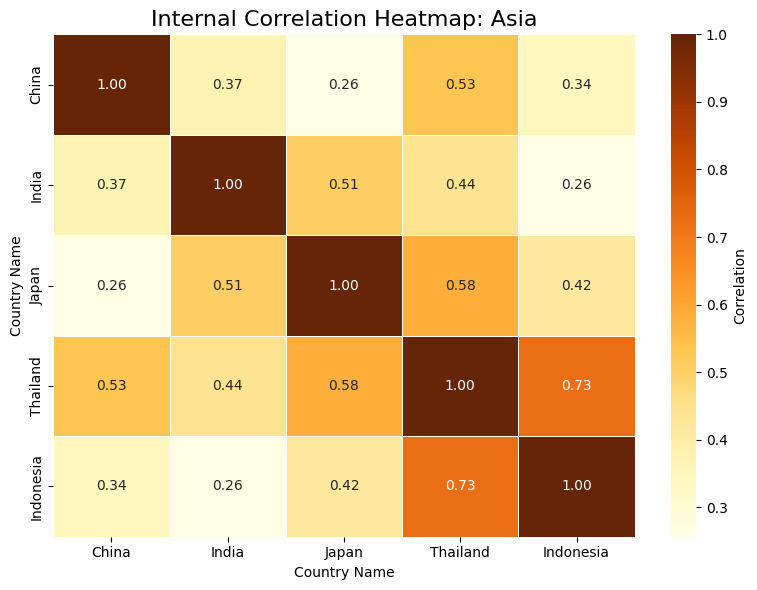

Average Internal Economic Correlation by Region:
North America: 0.86
Latin America: 0.67
Asia: 0.55

Average Cross-Regional Economic Correlation:
North America-Latin America: 0.68
North America-Asia: 0.38
Latin America-Asia: 0.50


<ipython-input-101-cc16e8107dbe>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


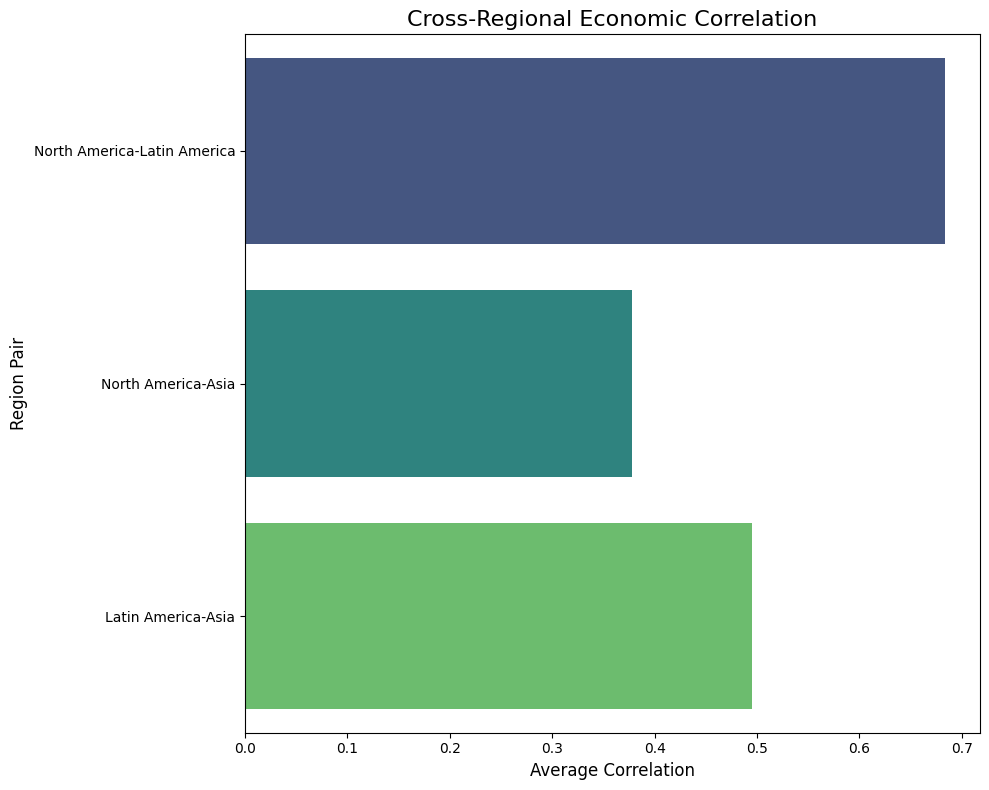

In [101]:
# Define regional groupings based on the countries in the dataset
regions = {
    "North America": ["United States", "Canada", "Mexico"],
    "Latin America": ["Brazil", "Argentina", "Mexico", "Colombia"],
    "Asia": ["China", "India", "Japan", "Thailand", "Vietnam", "Indonesia"]
}

# Filter regions to only include countries that exist in the pivot table
for region in regions:
    regions[region] = [country for country in regions[region] if country in gdp_growth_pivot.columns]

# Determine the global min and max correlation values for consistent color scaling
global_min = float('1')
global_max = float('-1')

for region, countries in regions.items():
    if len(countries) > 1:
        region_corr = gdp_growth_pivot[countries].corr()
        local_min = region_corr.min().min()
        local_max = region_corr.max().max()
        global_min = min(global_min, local_min)
        global_max = max(global_max, local_max)

# Internal regional correlation analysis for North America, Asia, and Latin America
internal_regional_corr = {}
heatmap_regions = ['North America', 'Latin America', 'Asia']

for region in heatmap_regions:
    countries = regions[region]
    if len(countries) > 1:
        region_corr = gdp_growth_pivot[countries].corr()
        avg_corr = region_corr.where(~region_corr.isna()).stack().mean()  # Average correlation excluding NaN
        internal_regional_corr[region] = avg_corr
        # Plot the heatmap with consistent color scaling
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            region_corr,
            annot=True,
            fmt=".2f",
            cmap="YlOrBr",
            linewidths=0.5,
            vmin=global_min,
            vmax=global_max,
            cbar_kws={'label': 'Correlation'}
        )
        plt.title(f"Internal Correlation Heatmap: {region}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Display internal regional interdependence
print("Average Internal Economic Correlation by Region:")
for region, corr in internal_regional_corr.items():
    print(f"{region}: {corr:.2f}")

# Cross-regional correlation analysis (avoid duplicates)
cross_regional_corr = {}
regions_pairs = [(r1, r2) for idx, r1 in enumerate(regions) for r2 in list(regions)[idx + 1:]]

for r1, r2 in regions_pairs:
    countries_r1 = regions[r1]
    countries_r2 = regions[r2]
    if countries_r1 and countries_r2:
        subset_corr = gdp_growth_pivot[countries_r1].corrwith(gdp_growth_pivot[countries_r2].mean(axis=1))
        avg_cross_corr = subset_corr.mean()
        cross_regional_corr[(r1, r2)] = avg_cross_corr

# Display cross-regional interdependence
print("\nAverage Cross-Regional Economic Correlation:")
for pair, corr in cross_regional_corr.items():
    print(f"{pair[0]}-{pair[1]}: {corr:.2f}")

# Plot the results as a heatmap for cross-regional economic interdependence
cross_regional_corr_df = pd.DataFrame(
    [
        {"Region Pair": f"{r1}-{r2}", "Correlation": corr}
        for (r1, r2), corr in cross_regional_corr.items()
    ]
)

plt.figure(figsize=(10, 8))
sns.barplot(
    x="Correlation",
    y="Region Pair",
    data=cross_regional_corr_df,
    palette="viridis"
)
plt.title("Cross-Regional Economic Correlation", fontsize=16)
plt.xlabel("Average Correlation", fontsize=12)
plt.ylabel("Region Pair", fontsize=12)
plt.tight_layout()
plt.show()

**From this, we can see that...**

### Part 3: Regression Model

In [102]:
# File path (update this path if the file is in a different location)
file_path = 'HRI VDEM.csv'  # Make sure the file is in the same directory or provide the full path

#this is from https://ourworldindata.org/grapher/human-rights-index-vdem##

# List of selected countries
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Load the dataset
df = pd.read_csv(file_path)

# Filter the dataset for the years 1992-2023 and the selected countries
filtered_df = df[(df['Year'].between(1992, 2023)) & (df['Entity'].isin(selected_countries))]

# Keep only the specified columns and rename 'Entity' to 'Country'
filtered_df = filtered_df[['Entity', 'Code', 'Year', 'Civil liberties index (best estimate, aggregate: average)']]
filtered_df.rename(columns={'Entity': 'Country', 'Civil liberties index (best estimate, aggregate: average)': 'Civil Liberties Index'}, inplace=True)

# Display the cleaned dataframe (optional)
print(filtered_df.head())

# Save the cleaned data to a new CSV file (optional)
filtered_df.to_csv('cleaned_HRI_VDEM.csv', index=False)

# File path (update this path if the file is in a different location)
file_path = 'economic-inequality-gini-index.csv'  # Make sure the file is in the same directory or provide the full path

#https://ourworldindata.org/grapher/economic-inequality-gini-index#

# List of selected countries
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Load the dataset
df = pd.read_csv(file_path)

# Filter the dataset for the years 1992-2023 and the selected countries
filtered_df = df[(df['Year'].between(1992, 2023)) & (df['Entity'].isin(selected_countries))]

# Keep only the specified columns and rename 'Entity' to 'Country'
filtered_df = filtered_df[['Entity', 'Code', 'Year', 'Gini coefficient']]
filtered_df.rename(columns={'Entity': 'Country'}, inplace=True)

# Display the cleaned dataframe (optional)
print(filtered_df.head())

# Save the cleaned data to a new CSV file (optional)
filtered_df.to_csv('cleaned_gini_index.csv', index=False)

# File path (update this path if the file is in a different location)
file_path = 'life-expectancy.csv'  # Make sure the file is in the same directory or provide the full path

# List of selected countries
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# File path (update this path if the file is in a different location)
file_path = 'life-expectancy.csv'  # Update this path if necessary

#https://ourworldindata.org/life-expectancy#

# List of selected countries
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Load the dataset
df = pd.read_csv(file_path)

# Identify the column with the data values (exclude 'Entity', 'Code', 'Year')
data_value_col = [col for col in df.columns if col not in ['Entity', 'Code', 'Year']][0]

# Filter for the years 1992-2023 and the selected countries
filtered_df = df[(df['Year'].between(1992, 2023)) & (df['Entity'].isin(selected_countries))]

# Keep only relevant columns and rename 'Entity' to 'Country'
filtered_df = filtered_df[['Entity', 'Code', 'Year', data_value_col]]
filtered_df.rename(columns={'Entity': 'Country'}, inplace=True)

# Save the cleaned data to a new CSV file (optional)
filtered_df.to_csv('cleaned_life_expectancy.csv', index=False)

# Display first few rows (optional)
print(filtered_df.head())

import pandas as pd

# File path (update this path if necessary)
file_path = 'political-regime.csv'  # Update this path if necessary

#https://ourworldindata.org/grapher/political-regime#

# List of selected countries
selected_countries = [
    "United States", "Germany", "Japan", "Australia", "Canada", "Saudi Arabia", "Poland", "Greece",
    "Brazil", "China", "South Africa", "Russia", "Argentina", "Mexico", "Turkey", "Thailand", "Colombia",
    "India", "Egypt", "Bangladesh", "Vietnam", "Kenya", "Indonesia",
    "Uganda", "Mozambique", "Rwanda", "Madagascar", "Tanzania"
]

# Load the dataset
df = pd.read_csv(file_path)

# Identify the column with the data values (exclude 'Entity', 'Code', 'Year')
data_value_col = [col for col in df.columns if col not in ['Entity', 'Code', 'Year']][0]

# Filter for the years 1992-2023 and the selected countries
filtered_df = df[(df['Year'].between(1992, 2023)) & (df['Entity'].isin(selected_countries))]

# Keep only relevant columns and rename 'Entity' to 'Country'
filtered_df = filtered_df[['Entity', 'Code', 'Year', data_value_col]]
filtered_df.rename(columns={'Entity': 'Country'}, inplace=True)

# Save the cleaned data to a new CSV file (optional)
filtered_df.to_csv('cleaned_political_regime.csv', index=False)

# Display first few rows (optional)
print(filtered_df.head())

##note here 0 is closed autocracy, 1 is electoral autocracy, 2 is electoral democracy, 3 is liberal democracy#


        Country Code  Year  Civil Liberties Index
1033  Argentina  ARG  1992                  0.926
1034  Argentina  ARG  1993                  0.926
1035  Argentina  ARG  1994                  0.926
1036  Argentina  ARG  1995                  0.926
1037  Argentina  ARG  1996                  0.925
      Country Code  Year  Gini coefficient
78  Australia  AUS  1995          0.325786
79  Australia  AUS  2001          0.334620
80  Australia  AUS  2003          0.334969
81  Australia  AUS  2004          0.330558
82  Australia  AUS  2008          0.354285
       Country Code  Year  Life Expectency
809  Argentina  ARG  1992          72.0958
810  Argentina  ARG  1993          72.3033
811  Argentina  ARG  1994          72.7317
812  Argentina  ARG  1995          72.8644
813  Argentina  ARG  1996          73.0565
       Country Code  Year  Political regime
794  Argentina  ARG  1992                 2
795  Argentina  ARG  1993                 2
796  Argentina  ARG  1994                 2
797  Arg

In [103]:
# File paths for the cleaned CSV files
gini_path = 'cleaned_gini_index.csv'
hri_path = 'cleaned_HRI_VDEM.csv'
life_expectancy_path = 'cleaned_life_expectancy.csv'
political_regime_path = 'cleaned_political_regime.csv'

# Load the cleaned CSV files
gini_df = pd.read_csv(gini_path)
hri_df = pd.read_csv(hri_path)
life_expectancy_df = pd.read_csv(life_expectancy_path)
political_regime_df = pd.read_csv(political_regime_path)

# Merge the datasets on 'Country', 'Year', and 'Code'
combined_df = gini_df.merge(hri_df, on=['Country', 'Year', 'Code'], how='outer')
combined_df = combined_df.merge(life_expectancy_df, on=['Country', 'Year', 'Code'], how='outer')
combined_df = combined_df.merge(political_regime_df, on=['Country', 'Year', 'Code'], how='outer')

# Save the combined data to a new CSV file
combined_df.to_csv('combined_dataset.csv', index=False)

# Display the first few rows of the combined dataframe (optional)
print(combined_df.head())


     Country Code  Year  Gini coefficient  Civil Liberties Index  \
0  Argentina  ARG  1992               NaN                  0.926   
1  Argentina  ARG  1993               NaN                  0.926   
2  Argentina  ARG  1994               NaN                  0.926   
3  Argentina  ARG  1995               NaN                  0.926   
4  Argentina  ARG  1996               NaN                  0.925   

   Life Expectency  Political regime  
0          72.0958               2.0  
1          72.3033               2.0  
2          72.7317               2.0  
3          72.8644               2.0  
4          73.0565               2.0  


In [104]:
# File paths for the datasets
combined_path = 'combined_dataset.csv'
final_dataset_path = 'Final_Dataset.xlsx'

# Step 1: Rename 'Country' to 'Country Name' in combined_dataset.csv
combined_df = pd.read_csv(combined_path)
combined_df.rename(columns={'Country': 'Country Name', 'Code': 'Country Code'}, inplace=True)
combined_df.to_csv('combined_dataset.csv', index=False)  # Save the updated file

# Step 2: Load the updated combined dataset and the Final_Dataset
combined_df = pd.read_csv(combined_path)
final_df = pd.read_excel(final_dataset_path)

# Step 3: Merge the datasets on 'Country Name', 'Year', and 'Code'
merged_df = combined_df.merge(final_df, on=['Country Name', 'Year', 'Country Code'])

# Step 4: Save the merged data to a new CSV file
merged_df.to_csv('final_merged_dataset.csv', index=False)

# Display the first few rows of the merged dataframe (optional)
print(merged_df.head())


  Country Name Country Code  Year  Gini coefficient  Civil Liberties Index  \
0    Argentina          ARG  1992               NaN                  0.926   
1    Argentina          ARG  1993               NaN                  0.926   
2    Argentina          ARG  1994               NaN                  0.926   
3    Argentina          ARG  1995               NaN                  0.926   
4    Argentina          ARG  1996               NaN                  0.925   

   Life Expectency  Political regime           GDP  Capital Stock  \
0          72.0958               2.0  313120000000   3.821158e+10   
1          72.3033               2.0  338818000000   4.660997e+10   
2          72.7317               2.0  358592000000   5.139950e+10   
3          72.8644               2.0  348389000000   4.773693e+10   
4          73.0565               2.0  367644000000   5.340632e+10   

   Savings Rate  Labour Force Growth Rate  Pop Growth Rate  Labour Force  \
0      0.110822                  0.02939

In [105]:
file_path = 'final_merged_dataset.csv'
df = pd.read_csv(file_path)
df_GDP = df[['GDP', 'Civil Liberties Index', 'Life Expectency']].dropna()

X = df_GDP[['Civil Liberties Index', 'Life Expectency']]
y = np.log(df_GDP['GDP']) #log transformation to scale down data
df_GDP["log(GDP)"] = y

GDP_model = LinearRegression()
GDP_model.fit(X, y)
y_pred = GDP_model.predict(X)

#model coefficients
intercept = GDP_model.intercept_
coefs = list(zip(X.columns, GDP_model.coef_))

# Calculate and print the performance metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Fit model: log(GDP) = {intercept:.3f} + {coefs[0][1]:.3f}*{coefs[0][0]} + {coefs[1][1]:.3f}*{coefs[1][0]}")

Mean Squared Error (MSE): 1.690384835403056
R-squared (R2): 0.6281140872813622
Fit model: log(GDP) = 14.202 + 0.253*Civil Liberties Index + 0.173*Life Expectency


A good regression model should minimize mean squared error such that it is close to 0. Our model however has a mean squared error of 1.69, which is not the most ideal but is expected for such a complex dataset. The r-squared value suggests that approximately 62.8% of the variance in $log(GDP)$ is explained by life expectancy and civil liberties index.

The interpretation of our model is as follows:
- Keeping life expectancy fixed, a 1 unit increase in civil liberties index contributes to a 0.253 increase to $log(GDP)$.
- Keeping the civil liberties index fixed, a 1 unit increase in life expectancy contributes to a 0.173 increase to $log(GDP)$.

[Text(0.5, 1.0, 'Regression: Life Expectancy vs log(GDP)')]

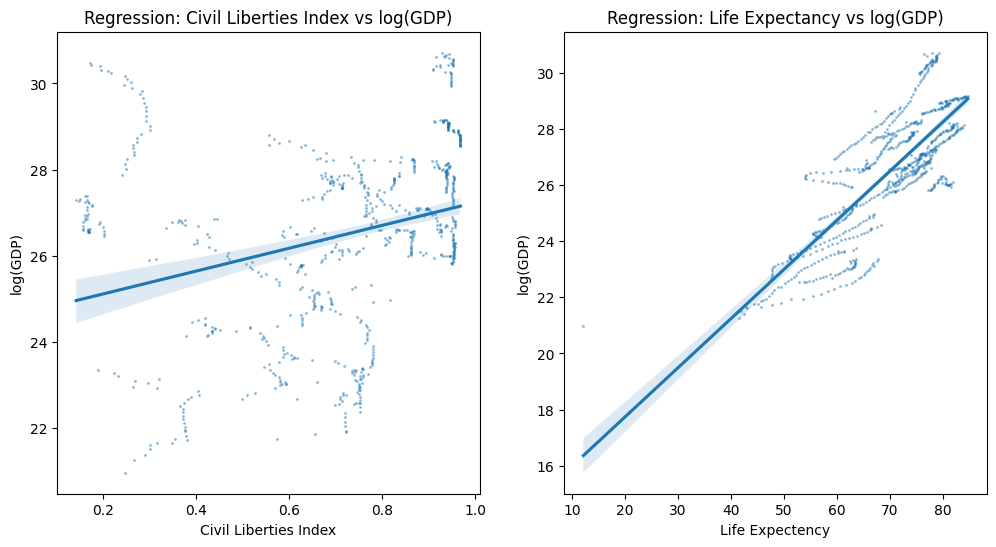

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# CLI Regression plot
sns.regplot(
    data=df_GDP, x="Civil Liberties Index", y="log(GDP)",
    scatter_kws=dict(s=1.5, alpha=0.35), ax = axes[0]
)
axes[0].set(title="Regression: Civil Liberties Index vs log(GDP)")

# Life Expectancy regression plot
sns.regplot(
    data=df_GDP, x="Life Expectency", y="log(GDP)",
    scatter_kws=dict(s=1.5, alpha=0.35), ax = axes[1]
)
axes[1].set(title="Regression: Life Expectancy vs log(GDP)")



We can see that the line of best fit seems more appropriate when plotted against life expetancy, as compared to the civil liberties index. One might consider removing the first explanatory variable out of the model, but such a simple single variable regression model would not reflect real life circumstances. Therefore, we can infer that based on the plots above, higher life expectancy can be a strong indicator of $log(GDP)$.

In [107]:
#Lets do our train-test split to ensure our model is not overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mse_train = mean_squared_error(y_train, GDP_model.predict(X_train))
mse_test = mean_squared_error(y_test, GDP_model.predict(X_test))
print(f"MSE on training set: {mse_train}")
print(f"MSE on test set: {mse_test}")

MSE on training set: 1.78515610108994
MSE on test set: 1.31253056831379


The MSE in our testing data is lower in comparison to the MSE in our training data. This may indicate a sign of underfitting in our regression model, our model might have coincidentally performed better on the testing set due to the nature of the testing data, or perhaps our model is not complex enough. However, this is to be expected as our model only includes 2 explanatory variables. We will now repeat the above analysis for GDP per capita as our predicted variable.

In [108]:
gdppc_df = df.copy()
gdppc_df["GDP Per Capita"] = gdppc_df["GDP"] / gdppc_df["Population"]
gdppc_df = gdppc_df[["GDP Per Capita", "Civil Liberties Index", "Life Expectency"]].dropna()

X_2 = gdppc_df[["Civil Liberties Index", "Life Expectency"]]
y_2 = np.log(gdppc_df["GDP Per Capita"])
gdppc_df["log(GDP Per Capita)"] = y_2
gdppc_df.head()

,GDP Per Capita,Civil Liberties Index,Life Expectency,log(GDP Per Capita)
0,9327.852168,0.926,72.0958,9.140760
1,9957.257773,0.926,72.3033,9.206057
2,10397.377738,0.926,72.7317,9.249309
3,9969.321335,0.926,72.8644,9.207268
4,10388.545575,0.925,73.0565,9.248459


In [109]:
GDP_pc_model = LinearRegression()
GDP_pc_model.fit(X_2, y_2)
y_pred_2 = GDP_pc_model.predict(X_2)

#model coefficients
intercept_2 = GDP_pc_model.intercept_
coefs_2 = list(zip(X_2.columns, GDP_pc_model.coef_))

# Calculate and print the performance metrics
mse_2 = mean_squared_error(y_2, y_pred_2)
r2_2 = r2_score(y_2, y_pred_2)
print(f"Mean Squared Error (MSE): {mse_2}")
print(f"R-squared (R2): {r2_2}")
print(f"Fit model: log(GDP Per Capita) = {intercept_2:.3f} + {coefs_2[0][1]:.3f}*{coefs_2[0][0]} + {coefs_2[1][1]:.3f}*{coefs_2[1][0]}")

Mean Squared Error (MSE): 0.5398192313957831
R-squared (R2): 0.7921249980485996
Fit model: log(GDP Per Capita) = -1.891 + 1.163*Civil Liberties Index + 0.137*Life Expectency


Our regression model for $log(GDP/capita)$ looks a lot better. The mean squared error is close to 0 at 0.53 which is a lot lower in comparison to thepredtiction model for $log(GDP)$. The $R^2$ value is also close to 1 than our previous model, which shows that around 79% of the variance in predicted $log(GDP/Capita)$ can be explained by our explanatory variables. We can easily say that this model has higher explanatory power despite having the same complexity as the other model.

Our interpretation of the model is as follows:
- Keeping life expectancy fixed, a 1 unit increase in civil liberties index contributes to a 1.163 increase to $log(GDP/Capita)$.
- Keeping the civil liberties index fixed, a 1 unit increase in life expectancy contributes to a 0.137 increase to $log(GDP/Capita)$.

[Text(0.5, 1.0, 'Regression: Life Expectancy vs log(GDP Per Capita)')]

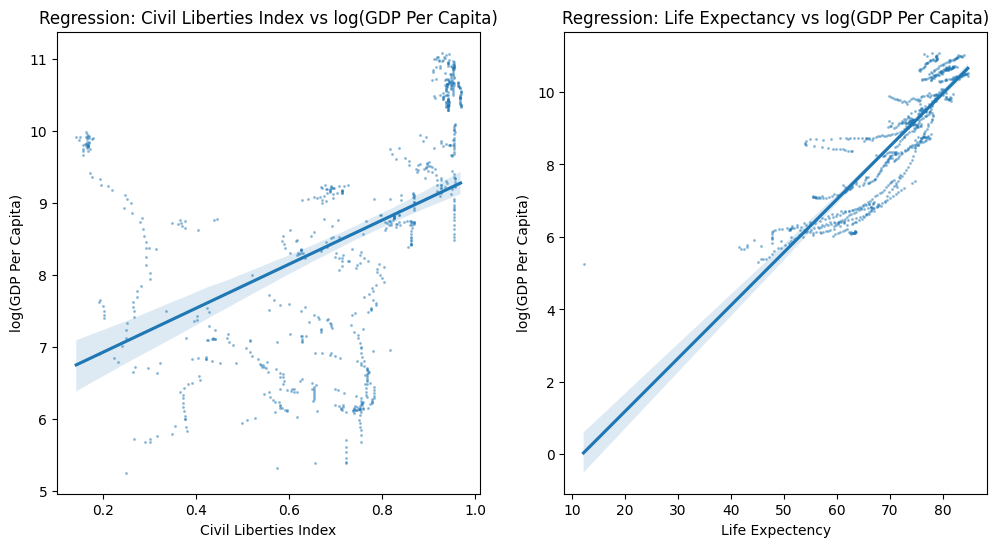

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# CLI Regression plot
sns.regplot(
    data=gdppc_df, x="Civil Liberties Index", y="log(GDP Per Capita)",
    scatter_kws=dict(s=1.5, alpha=0.35), ax = axes[0]
)
axes[0].set(title="Regression: Civil Liberties Index vs log(GDP Per Capita)")

# Life Expectancy regression plot
sns.regplot(
    data=gdppc_df, x="Life Expectency", y="log(GDP Per Capita)",
    scatter_kws=dict(s=1.5, alpha=0.35), ax = axes[1]
)
axes[1].set(title="Regression: Life Expectancy vs log(GDP Per Capita)")

Regression plots are similar as expected. GDP per capita is simply GDP scaled by division of population, so the correlational relationship between both variables still hold to a large extent. Moving on, we conduct the train-test split to check for overfitting in our model.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
mse_train = mean_squared_error(y_train, GDP_pc_model.predict(X_train))
mse_test = mean_squared_error(y_test, GDP_pc_model.predict(X_test))
print(f"MSE on training set: {mse_train}")
print(f"MSE on test set: {mse_test}")

MSE on training set: 0.5387667777296234
MSE on test set: 0.5440153778309919


We see that the model is a near excellent fit, there is hardly any difference between the training MSE and testing MSE. This concludes our regresional analysis, where we examine the predictive power of non-economic variables towards economic growth. The above analysis suggests that the predictive model for GDP per capita is more robust than the predictive model for GDP itself, indicating that civil liberty index and life expectancy have more explanatory power when it comes to indicating economic welfare, rather than actual economic output.

# Solow's Model: Computation and Application

To make a prediction model for a country's steady state condition, we must first define the steady-state condition of a economy. The idea focuses on the Cobb-Douglas function which we are familiar with (from lectures).

$$Y = F(K, L) = AL^{\alpha}K^{1-\alpha}$$
Where $Y$ denotes economic output, $A$ denotes total factor productivity (which can be interpreted as technological level), $L$ denotes labor, $K$ denotes capital and $\alpha$ denotes labor elasticity of output (making $1-\alpha$ the capital elasticity of output).

Y denotes output of the economy, we can denote the output per worker (labor) as
$$\frac{Y}{L} = \frac{AK^{\alpha}L^{1-\alpha}}{L}$$
$$\frac{Y}{L} = \frac{AK^{\alpha}L}{LL^{\alpha}}$$
$$\frac{Y}{L} = \frac{AK^{\alpha}}{L^{\alpha}}$$
$$\frac{Y}{L} = A(\frac{K}{L})^{\alpha}$$

In economics, variables divided by labor are interpreted as the growth rate of that variable (if applicable), growth rates are typically denoted as the lower case of its associated variable. Therefore, we can represent growth rate of output as:
$$y = Ak^{\alpha}$$

Our goal is to approximate the steady state condition of the economy, which occurs at equilibrium. Equilibrium condition states that saving and investment are equal, which means (according to neoclassical growth theory) the saving rate and investment are equal.

We denote the savings rate as $s = \frac{S}{L}$ and investment rate as $i = \frac{I}{L}$, but to fit this into our model, we must first understand the law of motion for capital.

First, we define our investment-saving identity:
$$S = I = sY$$

Which means savings rate is:
$$s = S/Y$$

In discrete time `t`, the law of motion defines capital stock in thefuture period as:
$$K_{t+1} = I + (1-\delta)K$$

Where $\delta$ is the depreciation rate of capital in the economy. Solow's model states that capital stock evolves by reinvestment that replaces depreciating capital, as capital grows from investment but declines from depreciation. This concept was used by Solow to derive the process of **capital accumulation** in the economy, which can be described as the "engine" of growth.

We can denote labour growth rate as $N/L = n$, the rate of effective depreciation of capital can be described as $n + \delta$. Avoiding tedious proof, Solow's growth equation is stated as a definiting for capital accumulation (denoted as $\dot{k}$):
$$\dot{k} = sy - (\delta + n)k$$

Solow states that steady condition is when capital accumulation is 0, which can be interpreted as the effective depreciation of capital being offset by saving in the economy.
$$0 = sy - (\delta + n)k$$
$$sy = (\delta + n)k$$

Subbing in our $y$ from above:

$$sAk^{\alpha} =(\delta + n)k$$

We find steady-state capital per worker by isolating $k$, and after some algebra we get:
$$k_{ss}^{*} = (\frac{sA}{n+\delta})^{\frac{1}{1-\alpha}}$$

**Definitions and Default Values:**
- \(k*\): Steady-state capital per worker.
- \(s\): Saving rate (fraction of output saved and invested).
- \(A\): Total factor productivity. (Default value often set to 1)
- \(n\): Labour growth rate.
- \(δ): Depreciation rate of capital. (Typically \(δ = 0.05\))
- \(α): Capital share of output. (Often \(α = 0.3\))



**Calculating Steady-State Capital per Worker (k)**

In [112]:
df = pd.read_excel("Final_Dataset.xlsx")

# Constants
A = 1  # Total factor productivity
delta = 0.05  # Depreciation rate
alpha = 0.3  # Capital share of output
s_f = 0.3
n_f = 0.02

# Compute average savings rate (s_fixed) and labor growth rate (n_fixed) for each country
savings_avg = df.groupby("Country Name")["Savings Rate"].mean()
labor_growth_avg = df.groupby("Country Name")["Labour Force Growth Rate"].mean()

# Merge these averages into the main dataset
df = df.merge(savings_avg.rename("s_fixed"), on="Country Name", how="left")
df = df.merge(labor_growth_avg.rename("n_fixed"), on="Country Name", how="left")

# Calculate steady-state capital per worker (k_ss)
df["Steady-State K"] = (((df["s_fixed"] * A) / (df["n_fixed"] + delta)) ** (1 / (1 - alpha)))

df["SSK"] = (((s_f * A) / (n_f + delta)) ** (1 / (1 - alpha)))/100

# Compute k(t) = Capital Stock / Labour Force
df["k_t"] = df["Capital Stock"] / df["Labour Force"]

# Initialize an array to store k(t+1)
k_t_plus_1 = []

# Apply the law of motion for capital
for _, group in df.groupby("Country Name"):
    k_t_country = group["k_t"].values
    savings_rate = group["Savings Rate"].values
    labor_growth_rate = group["Labour Force Growth Rate"].values
    k_t_plus_1_country = []
    for t in range(len(k_t_country) - 1):
        k_current = k_t_country[t]
        s_t = savings_rate[t]
        n_t = labor_growth_rate[t]
        # Law of motion: k(t+1) = s_t * A * k(t)^alpha + (1 - delta - n_t) * k(t)
        k_next = s_t * A * (k_current**alpha) + (1 - delta - n_t) * k_current
        k_t_plus_1_country.append(k_next)
    k_t_plus_1_country.append(None)  # The last year does not have k(t+1)
    k_t_plus_1.extend(k_t_plus_1_country)

# Add k(t+1) to the dataset
df["k_t+1"] = k_t_plus_1

df["K Growth Rate"] = (df["Capital Stock"]).pct_change()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              768 non-null    object 
 1   Country Code              768 non-null    object 
 2   Year                      768 non-null    int64  
 3   GDP                       768 non-null    int64  
 4   Capital Stock             768 non-null    float64
 5   Savings Rate              768 non-null    float64
 6   Labour Force Growth Rate  768 non-null    float64
 7   Pop Growth Rate           768 non-null    float64
 8   Labour Force              768 non-null    int64  
 9   Population                768 non-null    int64  
 10  s_fixed                   768 non-null    float64
 11  n_fixed                   768 non-null    float64
 12  Steady-State K            768 non-null    float64
 13  SSK                       768 non-null    float64
 14  k_t       

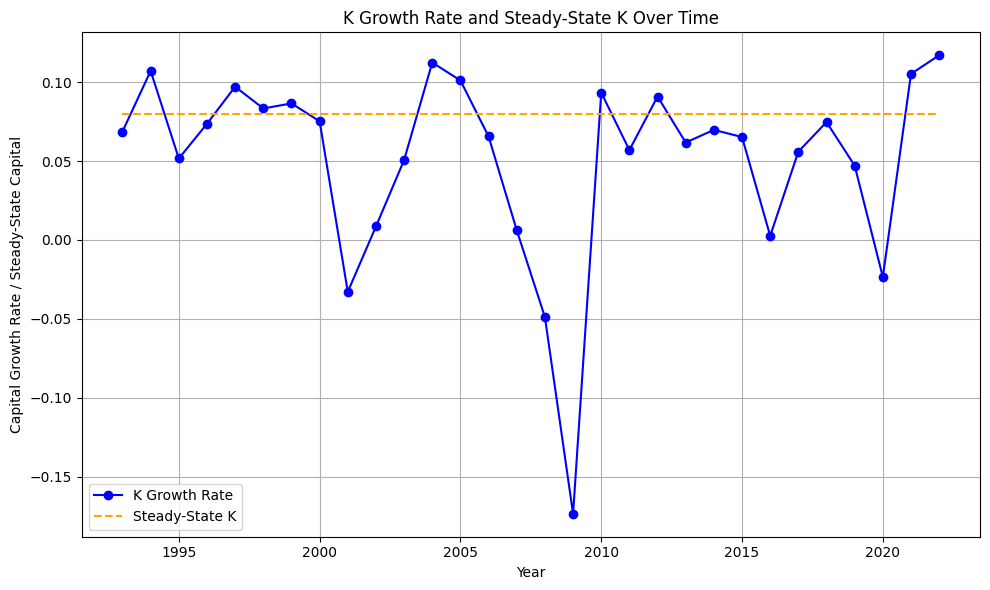

In [113]:
ldf = df[(df["Country Name"] == "United States") & (df["Year"] > 1992) & (df["Year"] < 2023)].sort_values("Year")
plt.figure(figsize=(10, 6))
plt.plot(ldf["Year"], ldf["K Growth Rate"], label="K Growth Rate", marker="o", color="blue")
plt.plot(ldf["Year"], ldf["SSK"], label="Steady-State K", linestyle="--", color="orange")
plt.xlabel("Year")
plt.ylabel("Capital Growth Rate / Steady-State Capital")
plt.title("K Growth Rate and Steady-State K Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**This is consistent with data because we see that the actual level of k hovers around steady state except during financial crises like during 2008/2009 Financial Crises and during 2020 pandemic.** Then replicate this 3 more times for other countries and explain too like Argentina it has a crises in 2001.

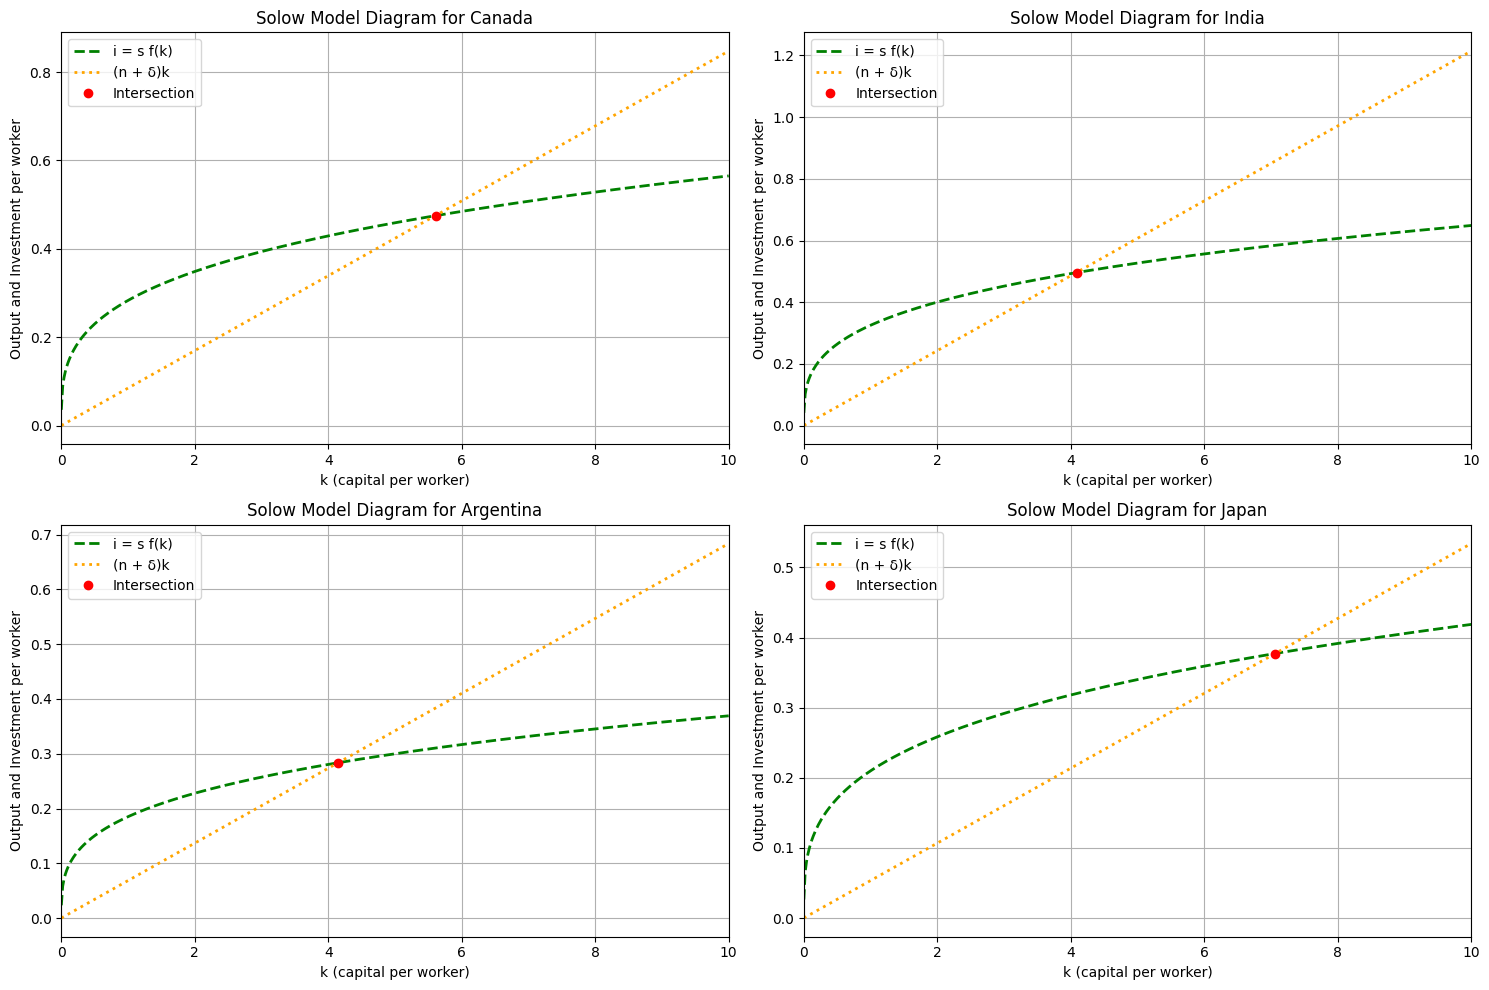

In [114]:
df = pd.read_excel("Final_Dataset.xlsx")

countries = ['Canada', 'India', 'Argentina', 'Japan']

#model parameters
alpha = 0.3
delta = 0.05
A = 1.0
k_values = np.linspace(0.001, 10, 500)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, country_name in enumerate(countries):
    country_data = df[df["Country Name"] == country_name].copy()
    if country_data.empty:
        continue

    # Extract parameters for the country
    s = country_data[country_data["Year"] == 2023]["Savings Rate"].values[0]
    n = country_data[country_data["Year"] == 2023]["Labour Force Growth Rate"].values[0]

    # Compute functions
    y_values = A * (k_values ** alpha)
    investment_values = s * y_values
    break_even_values = (n + delta) * k_values

    # Plot on the respective subplot
    ax = axes[i]
    ax.plot(k_values, investment_values, label="i = s f(k)", linewidth=2, linestyle='--', color='green')
    ax.plot(k_values, break_even_values, label="(n + δ)k", linewidth=2, linestyle=':', color='orange')

    # Numerically find the intersection point
    diff = np.abs(investment_values - break_even_values)
    idx = diff.argmin()
    k_star = k_values[idx]
    i_star = investment_values[idx]

    # Add a dot at the intersection point
    ax.plot(k_star, i_star, 'o', color='red', label="Intersection")

    # Customize the subplot
    ax.set_xlim(0, 10)
    ax.set_title(f"Solow Model Diagram for {country_name}")
    ax.set_xlabel("k (capital per worker)")
    ax.set_ylabel("Output and Investment per worker")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


**Then the following code will be our substitution for the IRF functions. We can just straight up say we didn't have a strong enough conceptual understanding or the necessary knowledge to create a VAR simulation of the IRF functions, so instead, we created this visualization to display shocks in k, both positive and negative, and simulate how it eventually will go back to steady state after a certain time**

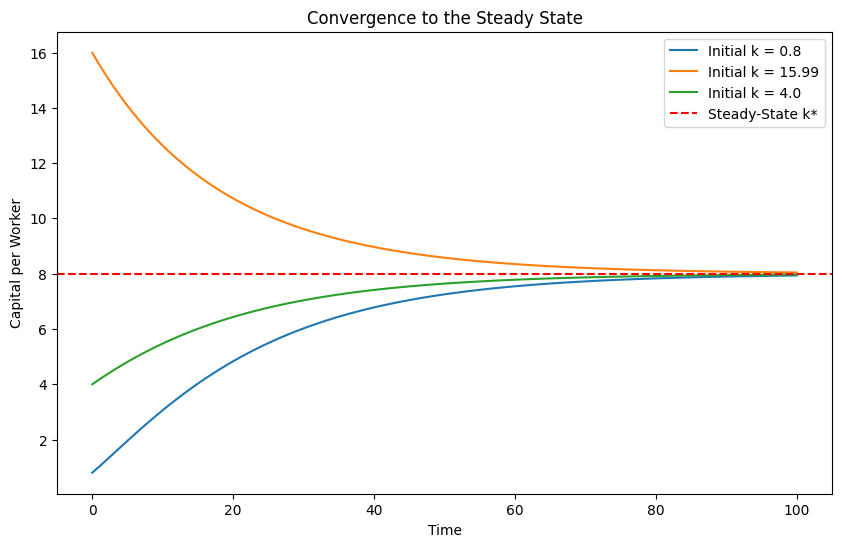

In [115]:
# Parameters
s = 0.3       # saving rate
delta = 0.05  # depreciation rate
n = 0.02      # population growth rate
alpha = 0.3   # capital share
A = 1         # TFP

# Compute steady-state capital per worker
k_star = ((s * A) / (n + delta))**(1/(1 - alpha))

# Let's say we have three economies with different initial conditions
initial_capitals = [0.1*k_star, 2*k_star, 0.5*k_star]  # some start below, some above

time_steps = 100
fig, ax = plt.subplots(figsize=(10,6))

for k0 in initial_capitals:
    k_path = [k0]
    k = k0
    for t in range(time_steps):
        # Law of motion: k_{t+1} = s A k_t^alpha + (1 - delta - n) k_t
        k = s*A*k**alpha + (1 - delta - n)*k
        k_path.append(k)
    ax.plot(k_path, label=f"Initial k = {round(k0, 2)}")

# Plot the steady-state line
ax.axhline(y=k_star, color='red', linestyle='--', label='Steady-State k*')

ax.set_xlabel("Time")
ax.set_ylabel("Capital per Worker")
ax.set_title("Convergence to the Steady State")
ax.legend()
plt.show()
